In [1]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm

import kalepy as kale

import holodeck as holo
from holodeck import plot
from holodeck.constants import MSOL

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

log = holo.log

## Plot Scaling Relation

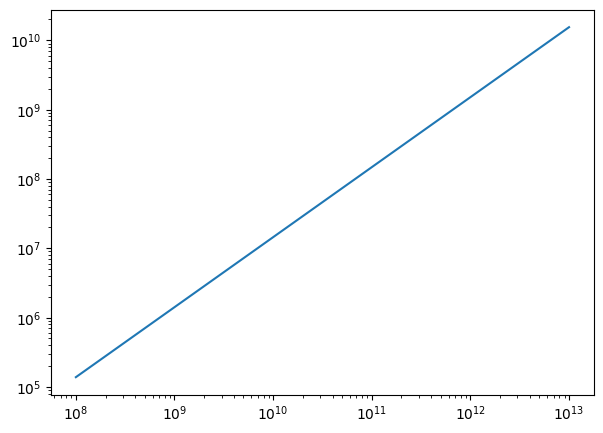

In [2]:
mmbulge = holo.relations.MMBulge_Standard()

mbulge = np.logspace(8, 13, 100) * MSOL

class host:
    pass

host.mbulge = mbulge
mbh = mmbulge.mbh_from_host(host, True)

fig, ax = plot.figax()
ax.plot(mbulge/MSOL, mbh/MSOL)

plt.show()

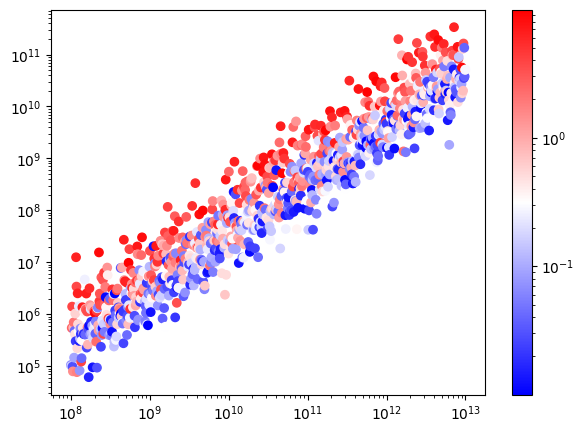

In [9]:
relation = holo.relations.MMBulge_Redshift_MM2013(zplaw=1.0)
NUM = 1e3

class host:
    mbulge = np.logspace(8, 13, int(NUM)) * MSOL
    redz = 10.0 ** np.random.uniform(-2, 1, mbulge.size)

mbh = relation.mbh_from_host(host, scatter=True)

smap = plot.smap(host.redz, cmap='bwr', log=True)
colors = smap.to_rgba(host.redz)

fig, ax = plot.figax()
ax.scatter(host.mbulge/MSOL, mbh/MSOL, color=colors)

plt.colorbar(smap, ax=ax)

plt.show()

## Reset Masses of Illustris-Based Binary Population

In [ ]:
pop = holo.population.Pop_Illustris()
ill_name = os.path.basename(pop._fname).split('_')[1]
print("Loaded", pop.size, "binaries from Illustris", ill_name)

mod_resamp = holo.population.PM_Resample(resample=2.0)
pop.modify(mod_resamp)
print("Population now has", pop.size, "elements")

In [ ]:
mmbulge = holo.relations.MMBulge_MM2013()
mod_MM2013 = holo.population.PM_Mass_Reset(mmbulge, scatter=True)
pop.modify(mod_MM2013)
# plot.plot_mbh_scaling_relations(pop)
plt.show()

## Redshift dependent mass evolution

In [ ]:
mbulge = pop.mbulge
redz = pop.redz[:, np.newaxis] * np.ones_like(mbulge)
mbef = pop.mass.copy()

mmbulge = holo.relations.MMBulge_Redshift_MM2013(zplaw=2.0)
mod_MM2013 = holo.population.PM_Mass_Reset(mmbulge, scatter=True)
pop.modify(mod_MM2013)
maft = pop.mass.copy()


mbulge, mbef, maft, redz = [vv.flatten() for vv in [mbulge, mbef, maft, redz]]
cmap = plot.smap(redz, cmap='bwr', log=True)
colors = cmap.to_rgba(redz)

fig, axes = plot.figax(figsize=[8, 6], nrows=2)

for ax, mval in zip(axes, [mbef, maft]):
    ax.scatter(mbulge/MSOL, mval/MSOL, color=colors, alpha=0.1, s=10)

plt.show()